In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from config import MODELS_DIR

2025-07-16 12:57:53.224 | INFO     | config:<module>:9 - PROJ_ROOT path is: /home/arys/projects/unsupervised_ml_experimentation


In [86]:
tranform = transforms.ToTensor()

In [87]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=tranform, download=True)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=tranform, download=True)

In [92]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=True, num_workers=4)

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=None, z_dim=2):

        super().__init__()
        if hidden_size is None:
            hidden_size = [128, 64, 8]

        self.encoder = nn.ModuleList()
        prev_size = input_size
        for size in hidden_size:
            self.encoder.append(nn.Linear(prev_size, size))
            prev_size = size

        self.encoder.append(nn.Linear(hidden_size[-1], z_dim))

    def forward(self, x):

        for i in range(len(self.encoder) - 1):
            x = torch.relu(self.encoder[i](x))
        x = self.encoder[-1](x)
        return x





In [6]:
class Decoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=None, z_dim=2):
        super().__init__()
        if hidden_size is None:
            hidden_size = [128, 64, 8]

        hidden_size.reverse()

        self.decoder = nn.ModuleList()
        prev_size = z_dim
        for size in hidden_size:
            self.decoder.append(nn.Linear(prev_size, size))
            prev_size = size

        self.decoder.append(nn.Linear(hidden_size[-1], input_size))

    def forward(self, x):
        for i in range(len(self.decoder) - 1):
            x = torch.relu(self.decoder[i](x))
        x = torch.sigmoid(self.decoder[-1](x))
        return x





In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
enc = Encoder().to(device)
dec = Decoder().to(device)


In [9]:
enc_compiled = enc
dec_compiled = dec

In [10]:
loss_fn = nn.MSELoss()
# optimizer_enc = torch.optim.Adam(enc.parameters())
# optimizer_dec = torch.optim.Adam(dec.parameters())
optimizer_enc = torch.optim.Adam(enc_compiled.parameters())
optimizer_dec = torch.optim.Adam(dec_compiled.parameters())


In [11]:
from tqdm import tqdm

torch.set_float32_matmul_precision('high')

train_loss = []
num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0

    for imgs, _ in train_dl:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        # latent = enc(imgs)
        # output = dec(latent)
        latent = enc_compiled(imgs)
        output = dec_compiled(latent)

        loss = loss_fn(output, imgs)

        train_epoch_loss += loss.cpu().detach().numpy()

        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()

        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()


    train_loss.append(train_epoch_loss)




100%|██████████| 200/200 [06:51<00:00,  2.06s/it]


In [12]:

torch.save(enc_compiled.state_dict(), 'enc.pth')
torch.save(dec_compiled.state_dict(), 'dec.pth')

In [13]:
enc_load = torch.load('enc.pth')
dec_load = torch.load('dec.pth')

In [18]:
train_dataset.data[0].shape

torch.Size([28, 28])

In [19]:
import matplotlib.pyplot as plt

def show_image_from_dataset(dataset, index=0):
    """
    Affiche une image 28x28 à partir d'un dataset torch.

    Paramètres :
    - dataset : torch.utils.data.Dataset (par ex. MNIST, FashionMNIST, etc.)
    - index : int, l'indice de l'exemple à afficher
    """
    img, label = dataset[index]  # img est un tensor, label est un entier ou un str
    if img.ndim == 3:  # (C, H, W)
        img = img.squeeze()  # enlève le canal si c'est (1, H, W)

    plt.imshow(img.numpy(), cmap='gray')
    plt.title(f"Label : {label}")
    plt.axis('off')
    plt.show()


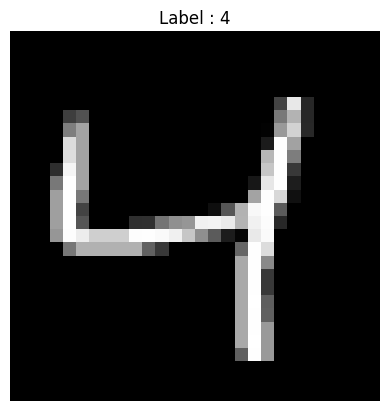

In [68]:
show_image_from_dataset(train_dataset, 2)

In [69]:
data_test = train_dataset.data[2].float().to(device)
data_test = data_test.view(1, -1)
x = enc.forward(data_test)
y = dec(x)
# type(y)

In [70]:
y = y.reshape(28, 28)

In [71]:
import matplotlib.pyplot as plt
import torch

def show_image_tensor(tensor, title=None):
    """
    Affiche un torch.Tensor représentant une image 28x28 ou 1x28x28.

    Paramètres :
    - tensor : torch.Tensor (28x28) ou (1x28x28)
    - title : str optionnel, titre à afficher
    """
    tensor = tensor.cpu().detach()
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("L'entrée doit être un torch.Tensor.")

    if tensor.ndim == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
        print(tensor.shape)# (1, 28, 28) → (28, 28)
    elif tensor.ndim != 2:
        raise ValueError(f"Tensor de forme invalide : {tensor.shape} (attendu 28x28 ou 1x28x28)")

    print(tensor.shape)
    plt.imshow(tensor.numpy(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


torch.Size([28, 28])


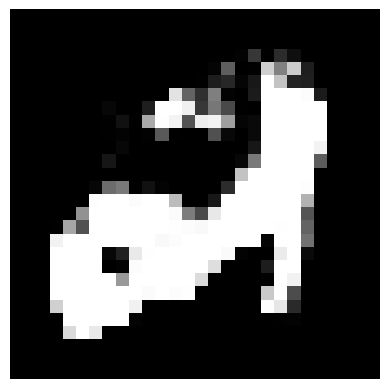

In [72]:
show_image_tensor(y)

In [75]:
import matplotlib.pyplot as plt
import torch

def show_original_and_reconstructed(dataset, encoder, decoder, n=5, device='cpu'):
    """
    Affiche n paires (original vs reconstruit) à partir d'un dataset et d'un autoencodeur.

    Paramètres :
    - dataset : torch.utils.data.Dataset
    - encoder : nn.Module (entrée flatten 784, sortie latent)
    - decoder : nn.Module (entrée latent, sortie flatten 784)
    - n : nombre d'exemples à afficher
    - device : 'cpu' ou 'cuda'
    """

    encoder.eval()
    decoder.eval()

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(4, 2*n))


    for i in range(n):
        data_test = dataset.data[i].float().to(device)
        data_test_flat = data_test.view(1, -1)
          # (1, 784)

        with torch.no_grad():
            z = enc.forward(data_test_flat)
            y = dec(z)
            recon = y.reshape(28, 28)
            # (1, latent_dim)


            # Original
        axes[i, 0].imshow(data_test.cpu().numpy(), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Reconstruit
        axes[i, 1].imshow(recon.cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Reconstruit")
        axes[i, 1].axis('off')

    plt.tight_layout()

        # Rec


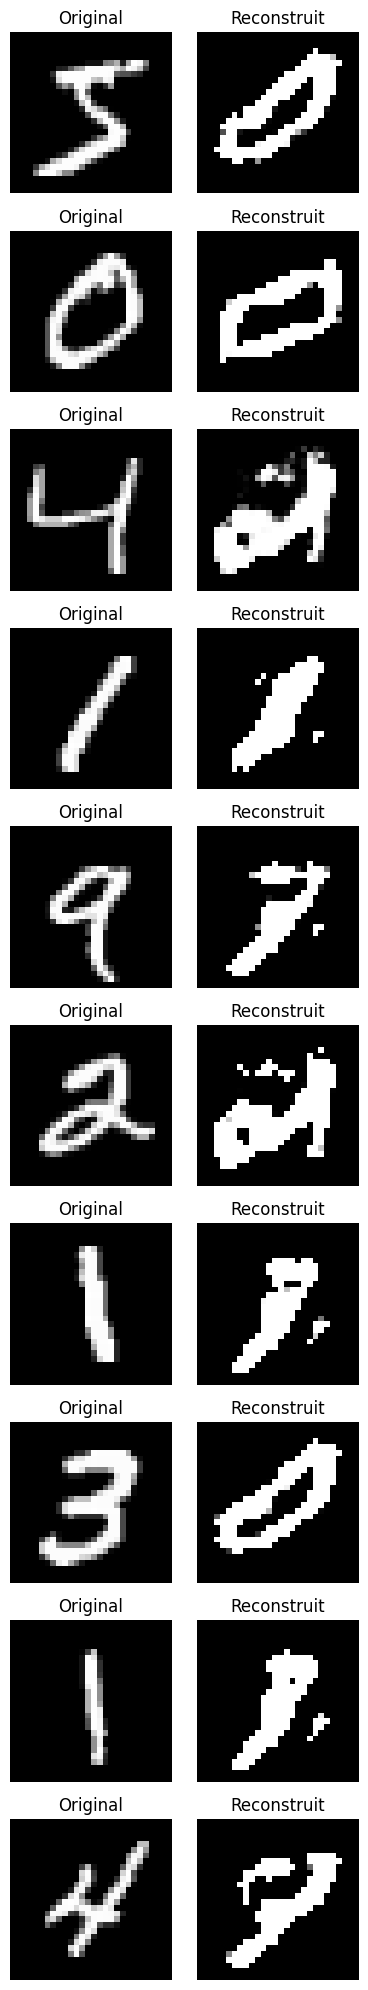

In [77]:
show_original_and_reconstructed(train_dataset, encoder=enc, decoder=dec, n=10, device=device)

In [149]:
import torch
from torch.utils.data import DataLoader

def get_latent_representations(dataset, encoder, batch_size=128, device="cpu"):
    """
    Retourne la représentation latente de tout le dataset passé dans l'encodeur.

    Paramètres :
    - dataset : torch.utils.data.Dataset (ex. MNIST)
    - encoder : nn.Module (doit recevoir des tensors 2D [batch_size, 784])
    - batch_size : int
    - device : 'cpu' ou 'cuda'

    Retour :
    - latent_vectors : torch.Tensor de forme (N, latent_dim)
    - labels : torch.Tensor de forme (N,) si dataset[i] = (image, label)
    """
    encoder.eval()


    all_latents = []
    all_labels = []
    # print(len(dataset))

    for i in range(len(dataset)):
        data_test = dataset.data[i].float().to(device)
        data_test_flat = data_test.view(1, -1)
          # (1, 784)
        # print(dataset.targets[i])

        with torch.no_grad():
            z = enc.forward(data_test_flat)
            all_latents.append(z)
            all_labels.append(dataset.targets[i].float())


    # print(all_labels)
    # print(all_latents)
    Z = torch.cat(all_latents, dim=0)  # (N, latent_dim)
    y = torch.tensor(all_labels) if all_labels else None
    # y = all_labels
    return Z, y


In [150]:
Z, y = get_latent_representations(train_dataset, encoder=enc, batch_size=256, device=device)


In [151]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def plot_latent_space(Z, y=None, method='pca', n_components=2, title=None):
    """
    Affiche la représentation 2D de l'espace latent Z.

    Paramètres :
    - Z : torch.Tensor ou np.array de forme (N, D)
    - y : torch.Tensor ou array de labels de forme (N,) (optionnel)
    - method : 'pca' ou 'tsne'
    - n_components : 2 (affichage 2D), ou 3 (3D si tu veux)
    - title : titre du graphe
    """

    if isinstance(Z, torch.Tensor):
        Z = Z.cpu().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().numpy()

    if Z.shape[1] > n_components:
        if method == 'pca':
            reducer = PCA(n_components=n_components)
        elif method == 'tsne':
            reducer = TSNE(n_components=n_components, init='random', learning_rate='auto')
        else:
            raise ValueError("Méthode inconnue : choisir 'pca' ou 'tsne'")
        Z_proj = reducer.fit_transform(Z)
    else:
        Z_proj = Z

    # Affichage
    plt.figure(figsize=(8, 6))
    if y is not None:
        scatter = plt.scatter(Z_proj[:, 0], Z_proj[:, 1], c=y, cmap='tab10', s=10, alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Classe", loc="best", fontsize='small')
    else:
        plt.scatter(Z_proj[:, 0], Z_proj[:, 1], s=10, alpha=0.7)

    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.title(title or f"Espace latent ({method.upper()})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [152]:
Z.shape

torch.Size([60000, 2])

In [153]:
y.shape

torch.Size([60000])

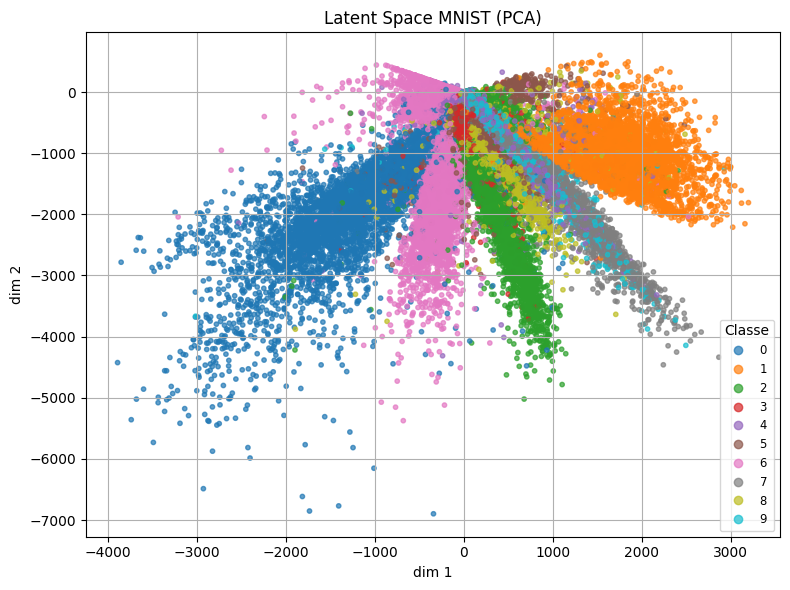

In [155]:
plot_latent_space(Z, y=y, method='pca', title='Latent Space MNIST (PCA)')


In [171]:
value_range_x =  [-4000, 3000]
value_range_y =  [-7000, 1000]
incr = 1000

ix = value_range_x[0]
iy = value_range_y[0]

repr_v = []

for i in range(-4000, 3000, 500):
    for j in range(-7000, 1000, 500):
        repr_v.append([i, j])

repr_v_tensor = torch.tensor(repr_v)

In [172]:
repr_v_tensor.shape

torch.Size([224, 2])

In [177]:
import math
a = math.sqrt(repr_v_tensor.shape[0])
a = int(a)
print(a)
print(a*a)

14
196


In [175]:
import matplotlib.pyplot as plt
import torch

def show_decoded_latent_grid(latent_points, decoder, grid_shape=(8, 7), image_shape=(28, 28), device='cpu'):
    """
    Affiche une grille d’images décodées à partir d’un ensemble de points latents.

    Paramètres :
    - latent_points : (N, latent_dim) — torch.Tensor
    - decoder : nn.Module — prend des points de latents en entrée
    - grid_shape : tuple (rows, cols)
    - image_shape : tuple (H, W)
    - device : cpu / cuda
    """
    decoder.eval()
    with torch.no_grad():
        inputs = latent_points.to(device)
        decoded = decoder(inputs).cpu()

    # reshape les images
    decoded = decoded.view(-1, *image_shape)  # (N, H, W)

    fig, axes = plt.subplots(*grid_shape, figsize=(grid_shape[1], grid_shape[0]))

    for idx, ax in enumerate(axes.flat):
        ax.imshow(decoded[idx].numpy(), cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()



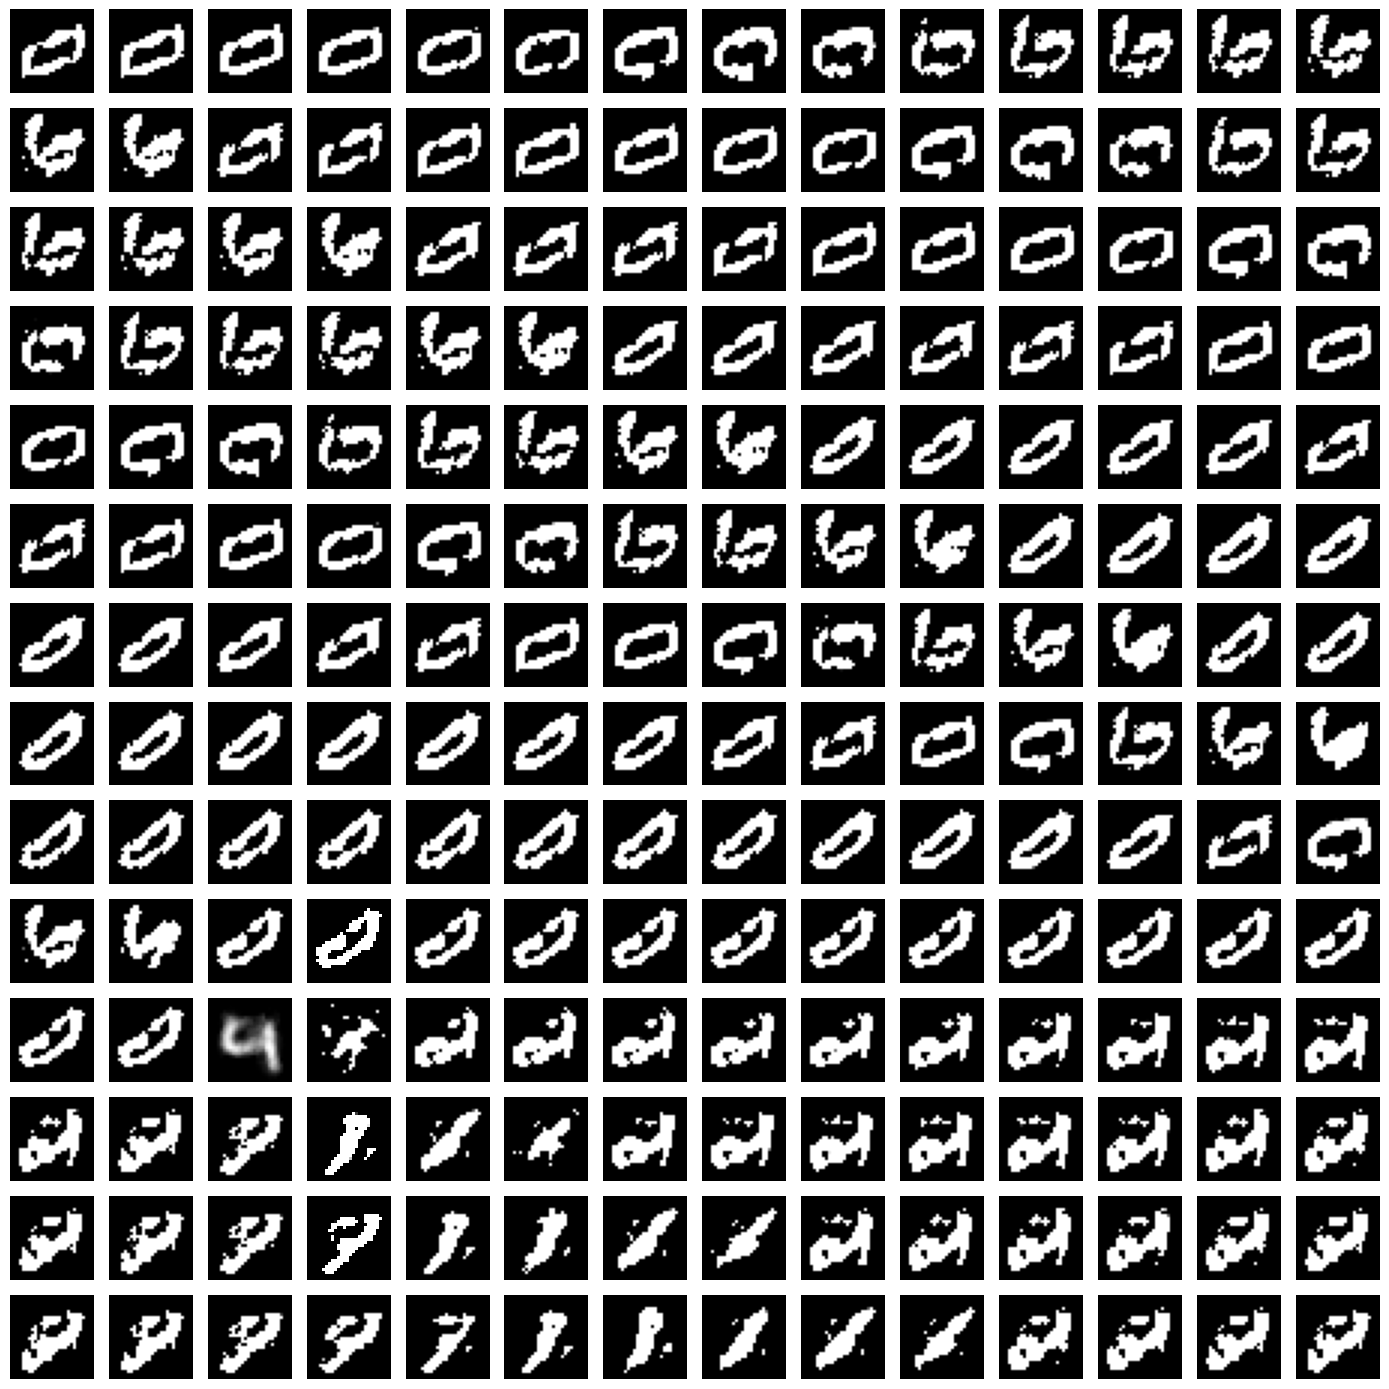

In [176]:
repr_v_tensor = torch.tensor(repr_v).float()
show_decoded_latent_grid(repr_v_tensor, decoder=dec, grid_shape=(a, a), device=device)